In [1]:
# ================================================
# ASL Alphabet Transfer Learning with MobileNetV2
# ================================================
# Goal:
# - Load images from folders using tf.data
# - Normalize and (optionally) augment images
# - Fine-tune a pre-trained MobileNetV2 backbone
# - Train, evaluate, plot metrics
# - Save + reload model safely under mixed precision
# -----------------------------------------------

# ---- Core scientific stack ----
import numpy as np        # Arrays, math ops (not strictly needed in this script, but handy)
import pandas as pd       # Tabular data (not used below; safe to remove if you like)
import matplotlib.pyplot as plt  # Plotting training curves

# ---- Deep learning frameworks ----
import tensorflow as tf   # TensorFlow: tensors, GPU execution, tf.data, Keras runtime
import keras              # Keras (TF-backed): model/layer APIs (in TF 2.x / Keras 3 this imports TF-Keras)

# ---- Keras building blocks ----
from keras import layers  # Common layers (Conv, Dense, Dropout, etc.)
from keras.applications import MobileNetV2  # Pretrained CNN (Imagenet weights)
from keras.layers import Dense, Dropout, GlobalAveragePooling2D  # Head layers used here
from keras.models import Sequential  # Simple container that stacks layers linearly
from keras.optimizers import Adam, RMSprop  # Optimizers; you picked RMSprop
from keras.utils import image_dataset_from_directory  # Build tf.data Dataset from folders

# ---- Mixed precision (FP16 on GPU) ----
from keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
# ^ Enables "mixed precision": most compute in float16 on supported GPUs (e.g., T4/V100/A100) for speed.
#   Keras automatically keeps certain numerically sensitive parts (like softmax/logits) in float32
#   IF you request dtype='float32' for that last Dense (you did—good!).
#   Automatic loss scaling is also handled for stability.


2025-09-04 11:53:41.309931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756986821.518949      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756986821.578811      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ---- Paths to your Kaggle dataset ----
train_dir = "/kaggle/input/signlanguagetransl/asl_alphabet_train/asl_alphabet_train"
test_dir  = "/kaggle/input/signlanguagetransl/asl_alphabet_test/asl_alphabet_test"
# NOTE: In this script we use train_dir and create a validation split from it.
#       test_dir is defined but not used below (you can add a final test evaluation if desired).

# ---- Build training/validation datasets from folders ----
# image_dataset_from_directory:
# - Expects structure: root/class_name/*.jpg
# - Returns a tf.data.Dataset yielding (images, labels) batches.
# - Labels are integer indices corresponding to class_names.
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),     # Images resized to MobileNetV2's expected input size
    batch_size=32,             # Number of images per batch
    validation_split=0.2,      # 80/20 split for train/val (based on filenames & seed)
    seed=42,                   # Keep split deterministic across runs
    subset="training"          # This creates the training portion
)

validation_ds = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    seed=42,
    subset="validation"        # This creates the validation portion
)

# ---- Normalization / Preprocessing ----
# Option A (your current choice): scale pixel values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
# NOTE: MobileNetV2's canonical preprocessing is to scale to [-1, 1].
# If you want to match pretrained weights more closely, you can instead do:
#   from keras.applications.mobilenet_v2 import preprocess_input
#   preprocessing = tf.keras.layers.Lambda(preprocess_input)
# and replace `normalization_layer` with `preprocessing` below.

# Apply normalization to datasets (keeps labels 'y' unchanged)
train = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation = validation_ds.map(lambda x, y: (normalization_layer(x), y))
# Mixed precision note: images are float32 after Rescaling; Keras will feed them to the model
# and cast to float16 automatically under the global policy.

# ---- Performance: pipeline tuning ----
AUTOTUNE = tf.data.AUTOTUNE

# Cache + prefetch:
# - cache(): keep preprocessed batches in memory (fast but can be heavy for large datasets)
# - prefetch(): overlaps data preparation with model execution (keeps GPU busy)
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)
# If you ever see memory issues on Kaggle, remove .cache() or use disk caching:
#   train = train.cache('/kaggle/working/train.cache').prefetch(AUTOTUNE)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.


I0000 00:00:1756986978.170575      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756986978.171249      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [3]:
# ---- Load pretrained CNN backbone (transfer learning) ----
conv_base = MobileNetV2(
    weights="imagenet",      # Start from ImageNet weights (general visual features)
    include_top=False,       # Exclude the original classifier so we can add our own
    input_shape=(224, 224, 3)
)
conv_base.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [5]:
# Fine-tuning policy:
conv_base.trainable = True
for layer in conv_base.layers[:-30]:
    layer.trainable = False
# Explanation:
# - First freeze most layers to keep the generic features stable.
# - Unfreeze the last ~30 layers so the network can adapt to ASL images.
# - You can later unfreeze more layers once your new head is stable (common 2-phase strategy).

# ---- On-the-fly data augmentation (applied only during training) ----
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augmentation")
# These stochastic layers run in training mode only. At inference, they pass images unchanged.

# ---- Build the classifier head on top of the backbone ----
model = Sequential()
model.add(data_augmentation)       # 1) augment
model.add(conv_base)               # 2) feature extractor (conv_base)
model.add(GlobalAveragePooling2D())# 3) spatially average feature maps -> feature vector
model.add(Dropout(0.3))            # 4) regularization to reduce overfitting
# Number of output units = number of classes. image_dataset_from_directory gives class names:
num_classes = len(train_ds.class_names)
# Mixed precision detail:
# Keep the final Dense in float32 to avoid numerical issues in softmax/logits under FP16.
model.add(Dense(num_classes, activation="softmax", dtype="float32"))

# ---- Compile: choose optimizer, loss, metrics ----
model.compile(
    optimizer=RMSprop(learning_rate=1e-5),   # Small LR for fine-tuning a pretrained net
    loss='sparse_categorical_crossentropy',  # Labels are integer-encoded (not one-hot)
    metrics=['accuracy']                      # Track accuracy during training
)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,526,400 (5.82 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [6]:
# ---- Train ----
# history records loss/accuracy per epoch for train & validation.
history = model.fit(
    train,
    epochs=5,
    validation_data=validation
)

# ---- Evaluate on validation set ----
loss, accuracy = model.evaluate(validation)
print("Validation Loss :", loss)
print("Validation Accuracy :", accuracy)

Epoch 1/5


I0000 00:00:1756987040.501993     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 264s 114ms/step - accuracy: 0.3702 - loss: 2.3762 - val_accuracy: 0.9395 - val_loss: 0.2715
Epoch 2/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 158s 73ms/step - accuracy: 0.9053 - loss: 0.3644 - val_accuracy: 0.9803 - val_loss: 0.0947
Epoch 3/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 157s 72ms/step - accuracy: 0.9556 - loss: 0.1627 - val_accuracy: 0.9890 - val_loss: 0.0504
Epoch 4/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 156s 72ms/step - accuracy: 0.9725 - loss: 0.0989 - val_accuracy: 0.9923 - val_loss: 0.0320
Epoch 5/5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 157s 72ms/step - accuracy: 0.9814 - loss: 0.0663 - val_accuracy: 0.9945 - val_loss: 0.0227
544/544 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.9941 - loss: 0.0231
Validation Loss : 0.022728661075234413
Validation Accuracy : 0.9945402145385742


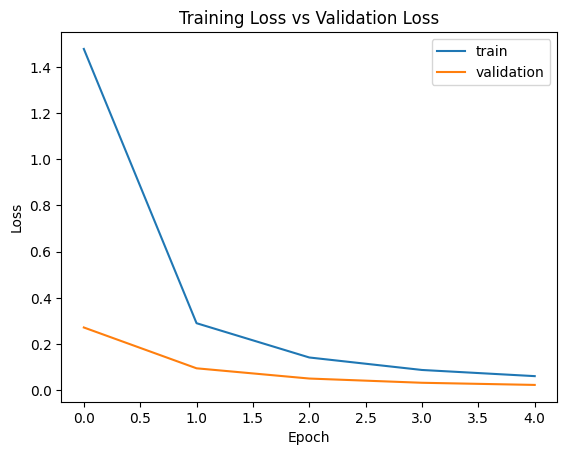

In [9]:
# ---- Plot learning curves ----
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

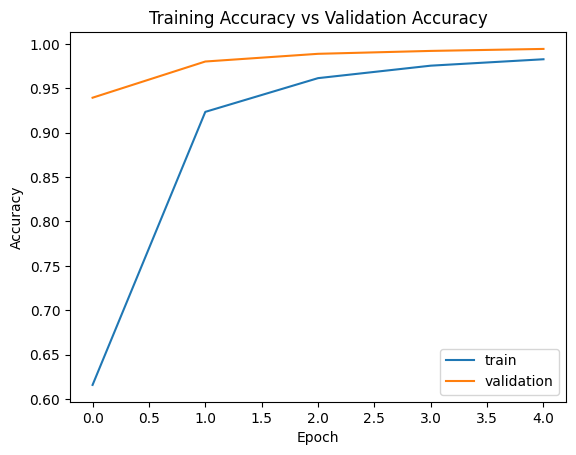

In [10]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [11]:
# ---- Save the trained Keras model ----
model.save("model.keras")  # Keras v3 native format (recommended going forward)

In [12]:
# ---- Reload the model ----
# safe_mode=False allows loading models that may contain TF ops or unregistered objects.
# It's useful if your graph includes things Keras doesn't serialize as standard layers.
loaded = tf.keras.models.load_model("model.keras", safe_mode=False)

In [13]:
# ---- (Optional) Rewrap to a "plain" single-input/single-output Keras Functional model ----
# Some environments/tools prefer a clean Keras graph with explicit inputs/outputs.
inp = loaded.inputs[0]
out = loaded.outputs[0]
fixed_model = tf.keras.Model(inputs=inp, outputs=out)

In [14]:
# Save the "fixed" version
fixed_model.save("model_fixed.keras")